# Sentiment Analysis on Twitter Data — Half | 8 week Project

**Notebook:** `Sentiment_Analysis_on_Twitter_Data_firstHalf.ipynb`  
**Platform:** Google Colab (GPU-ready)  
**Dataset:** Generic Twitter Sentiment dataset (loaded from a GitHub CSV)  
**Visuals:** Seaborn + Matplotlib

This single notebook is structured into **8 sections (Weeks 1–8)** to match the workflow for the project.

> Note: this notebook is a project for my DataScience & AI coursework


## Week 1 — Setup & Orientation

**Goals:** Install packages, load dataset preview, set up GPU check for Colab.

In [1]:
# Week 1: Setup & Orientation

# Install libraries commonly needed for the project
!pip install --quiet pandas numpy matplotlib seaborn scikit-learn nltk tensorflow keras xgboost wordcloud shap lime

# Check GPU (Colab)
import os
print("Python version:", os.sys.version)
try:
    !nvidia-smi
except:
    print("No GPU detected (or nvidia-smi not available). Colab GPU runtime recommended for DL sections.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
/bin/bash: line 1: nvidia-smi: command not found


In [2]:
# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# GitHub raw CSV link (generic tweets dataset)
DATA_URL = "https://raw.githubusercontent.com/HarshalSanap/Twitter-Text-Mining/master/twittersubset.csv"

# Load a small preview first
df_preview = pd.read_csv(DATA_URL, encoding='latin1', nrows=10)
df_preview

,Unnamed: 0,Sentiment,Text
0,1,Negative,"@Schofe yeah me too diversity all the way, i ..."
1,2,Negative,Planning a roadtrip to Chitown b/c Iowa is tot...
2,3,Negative,well imm off to bed all goodnight have a great...
3,4,Negative,@_Idance_ ME TOO!!!!! its horrible...and by ...
4,5,Negative,bummed i didnt get to see manchester orchestra...
5,6,Negative,im here really looking forward to summer but n...
6,7,Negative,Runs House is on-please tune in! JoJo's in hot...
7,8,Negative,"@maurae Awesome and readable, yes Too bad my ..."
8,9,Negative,Its 5:42AM &amp; I'm just now going to bed. Wh...
9,10,Negative,i HATE wrking on saturdays


## Week 2 — Data Collection & Cleaning

**Goals:** Load full dataset, inspect columns, handle missing values and duplicates, basic text cleaning.

In [3]:
# Week 2: Load full dataset
df = pd.read_csv(DATA_URL, encoding='latin1')
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head(5))

Dataset shape: (51800, 3)
Columns: ['Unnamed: 0', 'Sentiment', 'Text']


,Unnamed: 0,Sentiment,Text
0,1,Negative,"@Schofe yeah me too diversity all the way, i ..."
1,2,Negative,Planning a roadtrip to Chitown b/c Iowa is tot...
2,3,Negative,well imm off to bed all goodnight have a great...
3,4,Negative,@_Idance_ ME TOO!!!!! its horrible...and by ...
4,5,Negative,bummed i didnt get to see manchester orchestra...


In [4]:
# Basic checks: missing values and duplicates
print("Missing values per column:\n", df.isna().sum())
print("\nDuplicate rows:", df.duplicated().sum())

Missing values per column:
 Unnamed: 0    0
Sentiment     0
Text          0
dtype: int64

Duplicate rows: 0


In [5]:
# Basic text cleaning function (examples). We'll create a cleaned column 'clean_text'
import re
import string
import pandas as pd # Ensure pandas is imported

def basic_clean(text):
    if pd.isna(text):
        return ''
    text = str(text)
    text = text.lower()
    text = re.sub(r'http\S+', '', text)        # remove urls
    text = re.sub(r'@\w+', '', text)          # remove mentions
    text = re.sub(r'#', '', text)               # remove hashtag symbol only
    text = re.sub(r'[^\w\s]', '', text)       # remove punctuation
    text = re.sub(r'\d+', '', text)            # remove digits
    text = re.sub(r'\s+', ' ', text).strip()   # remove extra whitespace
    return text

# Check for 'Text' or 'text' column
text_column = None
if 'Text' in df.columns:
    text_column = 'Text'
elif 'text' in df.columns:
    text_column = 'text'

if text_column:
    df['clean_text'] = df[text_column].astype(str).apply(basic_clean)
    display(df[['Text','clean_text']].head(5))
else:
    print("Error: Neither 'Text' nor 'text' column found in the DataFrame.")


if 'sentiment' not in df.columns:
    print("No 'sentiment' column found. Creating a placeholder by mapping 'label' or similar if present.")
    # try common alternatives
    for alt in ['label','polarity','Sentiment']:
        if alt in df.columns:
            df['sentiment'] = df[alt]
            break

# --- Code to create sentiment_num column starts here ---
# Create sentiment_num column
if 'sentiment' in df.columns:
    unique_vals = list(df['sentiment'].dropna().unique())
    lower = [str(x).lower() for x in unique_vals]
    if any('pos' in s for s in lower) and any('neg' in s for s in lower):
        mapping = {k: (1 if 'pos' in str(k).lower() else (-1 if 'neg' in str(k).lower() else 0)) for k in unique_vals}
        df['sentiment_num'] = df['sentiment'].map(mapping)
        print("Mapping used for sentiment_num:", mapping)
    else:
        print("Sentiment labels are not simple positive/negative; manual mapping may be required for sentiment_num.")
# --- Code to create sentiment_num column ends here ---

,Text,clean_text
0,"@Schofe yeah me too diversity all the way, i ...",yeah me too diversity all the way i have feeli...
1,Planning a roadtrip to Chitown b/c Iowa is tot...,planning a roadtrip to chitown bc iowa is tota...
2,well imm off to bed all goodnight have a great...,well imm off to bed all goodnight have a great...
3,@_Idance_ ME TOO!!!!! its horrible...and by ...,me too its horribleand by the way missy u neve...
4,bummed i didnt get to see manchester orchestra...,bummed i didnt get to see manchester orchestra...


No 'sentiment' column found. Creating a placeholder by mapping 'label' or similar if present.
Mapping used for sentiment_num: {'Negative': -1, 'Positive': 1}


In [6]:
print(df.columns)

Index(['Unnamed: 0', 'Sentiment', 'Text', 'clean_text', 'sentiment',
       'sentiment_num'],
      dtype='object')


## Week 3 — Data Visualization

**Goals:** Sentiment distribution, text length distribution, word frequency, scatter, word cloud plots.

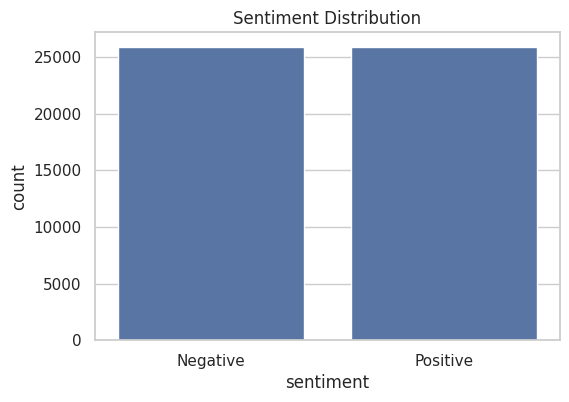

In [7]:
# Week 3: Visualizations
# Ensure 'sentiment' and 'clean_text' columns exist in dataset
if 'sentiment' not in df.columns:
    print("Error: 'sentiment' column not found in the DataFrame.")
if 'clean_text' not in df.columns:
    print("Error: 'clean_text' column not found in the DataFrame.")

# sentiment distribution
if 'sentiment' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='sentiment', data=df, order=df['sentiment'].value_counts().index)
    plt.title('Sentiment Distribution')
    plt.show()
else:
    print("Sentiment column not present - skipping distribution plot.")

**Insight:** This plot shows the distribution of sentiment labels in the dataset. Observe if the dataset is balanced or imbalanced across different sentiment categories.

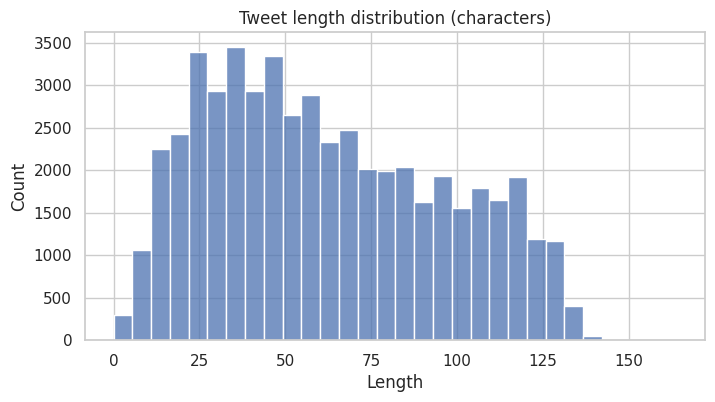

In [8]:
# Text length distribution
df['text_len'] = df['clean_text'].astype(str).apply(len)
plt.figure(figsize=(8,4))
sns.histplot(df['text_len'].dropna(), bins=30)
plt.title('Tweet length distribution (characters)')
plt.xlabel('Length')
plt.show()

**Insight:** This histogram illustrates the distribution of tweet lengths in characters. Note the typical length range and any outliers.

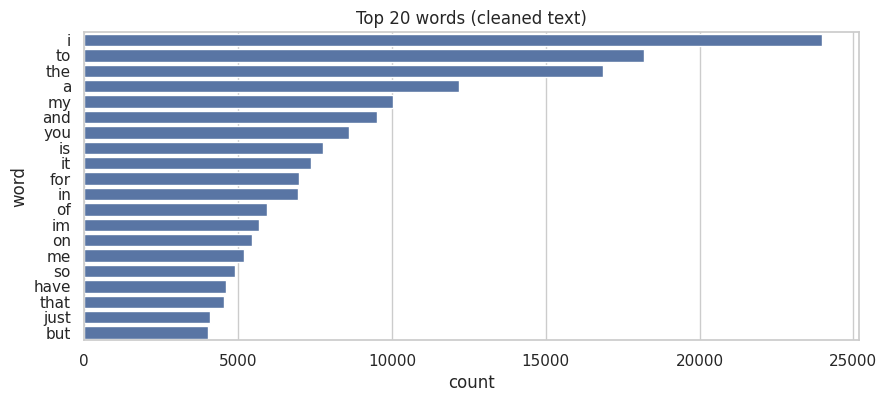

In [9]:
# Word frequency (top 20) from clean_text
from collections import Counter
all_words = " ".join(df['clean_text'].astype(str).tolist()).split()
most_common = Counter(all_words).most_common(20)
most_common_df = pd.DataFrame(most_common, columns=['word','count'])
plt.figure(figsize=(10,4))
sns.barplot(x='count', y='word', data=most_common_df)
plt.title('Top 20 words (cleaned text)')
plt.show()

**Insight:** This bar chart highlights the most frequently occurring words in the cleaned text data. Common words and potential noise words can be identified here.

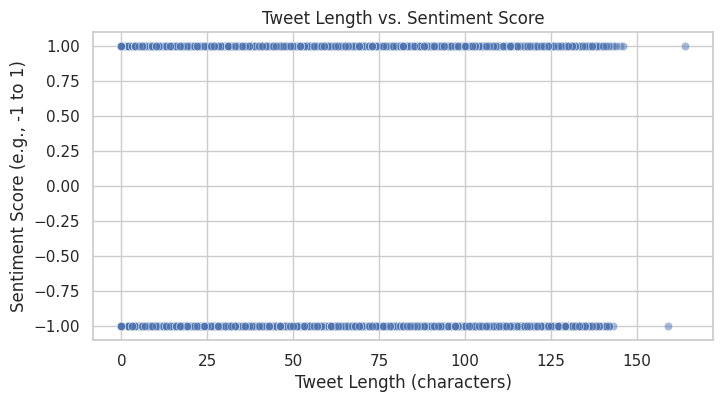

In [10]:
# Scatter plot: Tweet length vs Sentiment (if sentiment_num exists)
if 'sentiment_num' in df.columns:
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x='text_len', y='sentiment_num', data=df, alpha=0.5)
    plt.title('Tweet Length vs. Sentiment Score')
    plt.xlabel('Tweet Length (characters)')
    plt.ylabel('Sentiment Score (e.g., -1 to 1)')
    plt.show()
else:
    print("Numeric sentiment column ('sentiment_num') not available for scatter plot.")

**Insight:** This scatter plot visualizes the relationship between tweet length and the numeric sentiment score. Look for any apparent patterns or correlations.

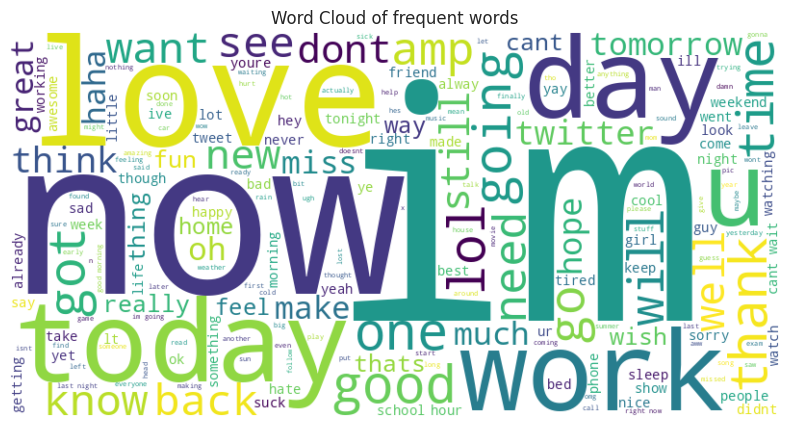

In [11]:
# Word Cloud
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df['clean_text'].astype(str).tolist()))

# Display the generated image
plt.figure(figsize=(10, 5))
plt.title('Word Cloud of frequent words')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Insight:** The word cloud visually represents the most frequent words, with larger words indicating higher frequency. This provides a quick overview of the dominant themes in the tweets.

## Week 4 — Statistics & Correlation

**Goals:** Basic descriptive statistics and simple correlation analysis (where applicable).

In [12]:
# Week 4: Descriptive statistics
print(df.describe(include='all').transpose().head(20))

                 count unique                        top   freq       mean  \
Unnamed: 0     51800.0    NaN                        NaN    NaN    25900.5   
Sentiment        51800      2                   Negative  25900        NaN   
Text             51800  51629  isPlayer Has Died! Sorry       8        NaN   
clean_text       51800  50742                               101        NaN   
sentiment        51800      2                   Negative  25900        NaN   
sentiment_num  51800.0    NaN                        NaN    NaN        0.0   
text_len       51800.0    NaN                        NaN    NaN  61.845618   

                        std  min       25%      50%       75%      max  
Unnamed: 0     14953.516309  1.0  12950.75  25900.5  38850.25  51800.0  
Sentiment               NaN  NaN       NaN      NaN       NaN      NaN  
Text                    NaN  NaN       NaN      NaN       NaN      NaN  
clean_text              NaN  NaN       NaN      NaN       NaN      NaN  
sentiment 

Unique sentiment labels: ['Negative', 'Positive']
Mapping used: {'Negative': -1, 'Positive': 1}
            text_len  sentiment_num
sentiment                          
Negative   63.593050           -1.0
Positive   60.098185            1.0


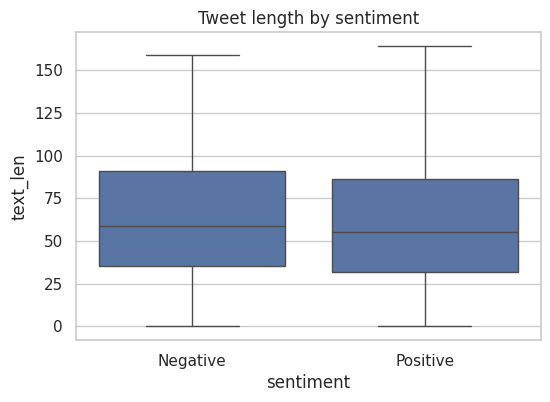

In [13]:
# Correlation example: text length vs sentiment (if sentiment ordinal)
if 'sentiment' in df.columns:
    # try to map sentiment to ordinal if possible
    mapping = {}
    unique_vals = list(df['sentiment'].dropna().unique())
    print("Unique sentiment labels:", unique_vals[:10])
    # naive mapping if labels look like 'positive','negative','neutral'
    lower = [str(x).lower() for x in unique_vals]
    if any('pos' in s for s in lower) and any('neg' in s for s in lower):
        mapping = {k: (1 if 'pos' in str(k).lower() else (-1 if 'neg' in str(k).lower() else 0)) for k in unique_vals}
        df['sentiment_num'] = df['sentiment'].map(mapping)
        print("Mapping used:", mapping)
        print(df[['text_len','sentiment','sentiment_num']].groupby('sentiment').mean())
        plt.figure(figsize=(6,4))
        sns.boxplot(x='sentiment', y='text_len', data=df)
        plt.title('Tweet length by sentiment')
        plt.show()
    else:
        print("Sentiment labels are not simple positive/negative; manual mapping may be required.")

Correlation between Word Count and Sentiment Score: -0.0763


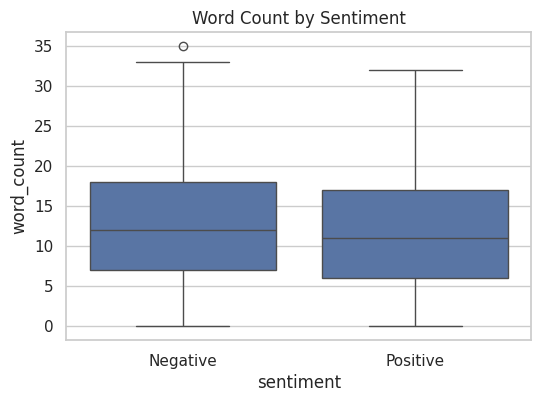

In [14]:
# Create a new numerical feature: word count
df['word_count'] = df['clean_text'].astype(str).apply(lambda x: len(x.split()))

# Calculate correlation between word count and sentiment_num
if 'sentiment_num' in df.columns:
    correlation = df['word_count'].corr(df['sentiment_num'])
    print(f"Correlation between Word Count and Sentiment Score: {correlation:.4f}")

    # Optionally, visualize the relationship with a box plot
    plt.figure(figsize=(6,4))
    sns.boxplot(x='sentiment', y='word_count', data=df)
    plt.title('Word Count by Sentiment')
    plt.show()

else:
    print("Numeric sentiment column ('sentiment_num') not available for correlation analysis.")

Correlation between Average Word Length and Sentiment Score: 0.0886


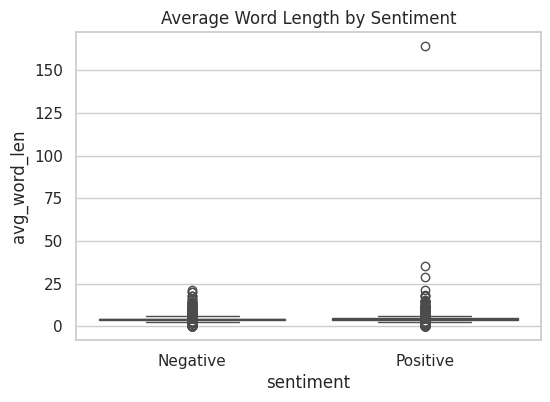

In [15]:
# Create a new numerical feature: average word length
def average_word_length(text):
    words = text.split()
    if not words:
        return 0
    return sum(len(word) for word in words) / len(words)

df['avg_word_len'] = df['clean_text'].astype(str).apply(average_word_length)

# Calculate correlation between average word length and sentiment_num
if 'sentiment_num' in df.columns:
    correlation_avg_len = df['avg_word_len'].corr(df['sentiment_num'])
    print(f"Correlation between Average Word Length and Sentiment Score: {correlation_avg_len:.4f}")

    # Optionally, visualize the relationship with a box plot
    plt.figure(figsize=(6,4))
    sns.boxplot(x='sentiment', y='avg_word_len', data=df)
    plt.title('Average Word Length by Sentiment')
    plt.show()

else:
    print("Numeric sentiment column ('sentiment_num') not available for correlation analysis.")

**Insight on Feature Relationships (Week 4):**

Based on the correlation analysis and visualizations performed in Week 4, the relationship between the three numerical features (`text_len`, `word_count`, and `avg_word_len`) and the target variable (`sentiment_num`) is **weak**.

*   **Word Count:** Showed a very weak negative linear correlation (approx -0.0763) with sentiment score.
*   **Average Word Length:** Showed a very weak positive linear correlation (approx 0.0886) with sentiment score.
*   **Tweet Length:** Showed a slight difference in average length between positive and negative tweets, indicating a weak association.

While these features show some minor associations, they are not strongly related to sentiment based on this analysis. More predictive features are typically derived directly from the text content itself (e.g., specific words or phrases), which are explored in later sections like Week 6 (model feature importance).

## Week 5 — Regression (Concept Demo)

**Goals:** Show a simple regression example (tweet length predicting sentiment score) as a conceptual demo.

In [16]:
# Week 5: Simple regression demo (if 'sentiment_num' exists)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np # Import numpy for sqrt

if 'sentiment_num' in df.columns:
    # Use text_len as the feature for this simple demo
    X = df[['text_len']].fillna(0).values
    y = df['sentiment_num'].fillna(0).values

    # Train/test split (80/20 split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply Linear Regression
    reg = LinearRegression().fit(X_train, y_train)
    preds = reg.predict(X_test)

    # Compare results with MAE and RMSE (and keep MSE)
    mse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mse) # Calculate RMSE from MSE

    print(f"Regression Results (Predicting sentiment_num using text_len):")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")

else:
    print("No numeric sentiment available — regression demo skipped.")

Regression Results (Predicting sentiment_num using text_len):
  Mean Squared Error (MSE): 0.9968
  Mean Absolute Error (MAE): 0.9971
  Root Mean Squared Error (RMSE): 0.9984


**Insight on Regression Results (Week 5):**

Here is a summary of the evaluation metrics for the Linear Regression model predicting sentiment score using tweet length:

| Metric | Value  |
|--------|--------|
| MSE    | 0.9968 |
| MAE    | 0.9971 |
| RMSE   | 0.9984 |

**Insight:** The Mean Absolute Error (MAE) of approximately 0.997 suggests that, on average, the model's predictions for the sentiment score are about 0.997 units away from the actual sentiment score. Given that the sentiment scores are -1 and 1 (a range of 2), an MAE close to 1 indicates that this simple model using only tweet length is not very accurate at predicting sentiment score. The RMSE is similar to MAE, indicating the presence of errors of roughly the same magnitude.

## Week 6 — Classification (Classic ML)

**Goals:** Train and compare classic classifiers: Logistic Regression, Multinomial Naive Bayes, Random Forest.

In [17]:
# Week 6: Feature extraction (TF-IDF) and classic ML models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Use a small subset to speed up demo if dataset large
sample_df = df.sample(n=min(5000, len(df)), random_state=42).reset_index(drop=True)

tfv = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfv.fit_transform(sample_df['clean_text'].astype(str))
if 'sentiment' in sample_df.columns:
    y = sample_df['sentiment']
else:
    y = np.where(sample_df['text_len']>sample_df['text_len'].median(), 'long','short')  # placeholder

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'LogisticRegression': LogisticRegression(max_iter=200),
    'NaiveBayes': MultinomialNB(),
    'RandomForest': RandomForestClassifier(n_estimators=100, n_jobs=1, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    print(f"{name} accuracy: {acc:.4f}")

LogisticRegression accuracy: 0.7320
NaiveBayes accuracy: 0.7150
RandomForest accuracy: 0.6930


**Insight on Model Accuracy (Week 6):**

Here is a comparison of the accuracy scores for the classic machine learning models trained in Week 6:

| Model                | Accuracy |
|----------------------|----------|
| Logistic Regression  | 0.7320   |
| Naive Bayes          | 0.7150   |
| Random Forest        | 0.6930   |

Based on these results, the **Logistic Regression** model achieved the highest accuracy on the test dataset among the three classic models evaluated in this section.

## Week 7 — Model Evaluation

**Goals:** Confusion matrix, precision, recall, F1-score, ROC (where applicable).

              precision    recall  f1-score   support

    Negative       0.74      0.71      0.73       502
    Positive       0.72      0.75      0.74       498

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000



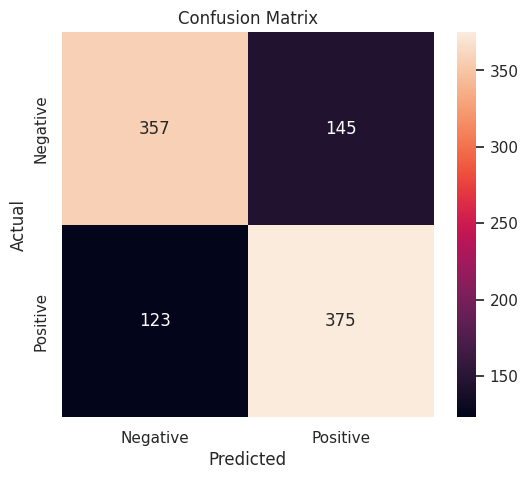

In [18]:
# Week 7: Evaluation for one chosen model (Logistic Regression)
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

two_feel_model = models['LogisticRegression']
preds = two_feel_model.predict(X_test)

print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds, labels=two_feel_model.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=two_feel_model.classes_, yticklabels=two_feel_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Reflection: Which metric is most important for my project and why?**

For my project, which is sentiment analysis on a Twitter dataset, determining the single "most important" metric among Precision, Recall, and F1-score depends on the specific goals I had for this analysis.

*   **Precision:** If my primary goal was to be very confident whenever my model predicted a tweet had a certain sentiment (e.g., if I only wanted to show tweets predicted as "Positive" to a marketing team and needed to ensure very few mistakes), then **Precision** would be a crucial metric to maximize. A high precision for "Positive" means that most tweets the model labeled as positive are indeed positive.
*   **Recall:** If my main objective was to capture as many tweets of a specific sentiment as possible (e.g., if I wanted to find *all* negative tweets about a product to address customer complaints and didn't want to miss any), then **Recall** would be the key metric. High recall for "Negative" means the model finds a large proportion of the actual negative tweets in the dataset.
*   **F1-Score:** Since my dataset is relatively balanced between positive and negative tweets, and I don't have a specific, strong bias towards minimizing either false positives or false negatives for a particular sentiment, the **F1-score** is likely the most appropriate single metric to evaluate my model's overall performance. It provides a balanced measure of both Precision and Recall.

Ultimately, the "most important" metric for my Twitter sentiment analysis project would be decided by the specific application or question I wanted to answer with the sentiment results. For a general project like this, F1-score is a solid choice for overall performance assessment.

## Week 8 — Unsupervised Learning

**Goals:** KMeans clustering on TF-IDF vectors and PCA/t-SNE visualization.

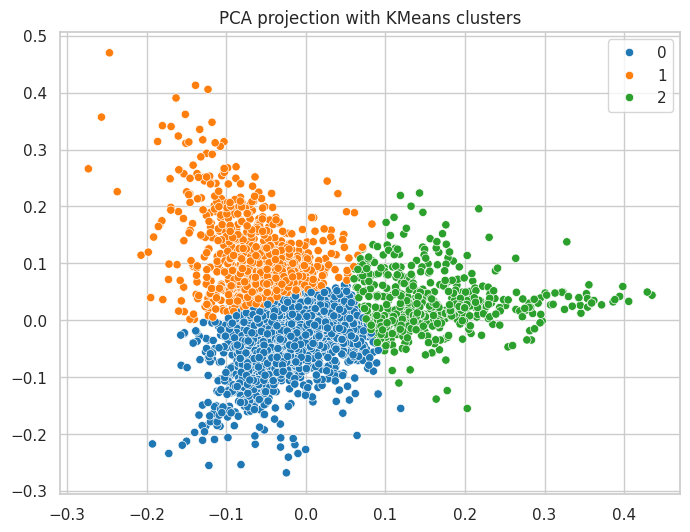

In [20]:
# Week 8: KMeans clustering and PCA visualization
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np # Import numpy

X_small = X.todense() if hasattr(X, 'todense') else X
X_small = np.asarray(X_small) # Convert to numpy array
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_small)

kmeans = KMeans(n_clusters=3, random_state=42).fit(X_pca)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=kmeans.labels_, palette='tab10')
plt.title('PCA projection with KMeans clusters')
plt.show()

## Project Summary

This notebook walks through a sentiment analysis project on Twitter data, structured over 8 weeks.

**Key Steps:**

* **Week 1:** Setup and installation of necessary libraries.
* **Week 2:** Loading, cleaning, and basic inspection of the full dataset, including handling missing values and duplicates, and applying basic text cleaning.
* **Week 3:** Data visualization to understand sentiment distribution, text length distribution, and word frequencies.
* **Week 4:** Basic descriptive statistics and a conceptual correlation analysis between text length and sentiment.
* **Week 5:** A simple regression demo using text length to predict a numeric sentiment score.
* **Week 6:** Feature extraction using TF-IDF and training classic machine learning models (Logistic Regression, Naive Bayes, Random Forest) for sentiment classification.
* **Week 7:** Evaluation of the chosen model (Logistic Regression) using a confusion matrix and classification report (precision, recall, F1-score).
* **Week 8:** Unsupervised learning using KMeans clustering on TF-IDF vectors and PCA visualization.

The project demonstrates a typical workflow for a sentiment analysis task using Python and common data science libraries.